## Import Packages

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.models import Model, load_model
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Add
from tensorflow.keras.layers import GlobalMaxPooling2D, Reshape
from tensorflow.keras.layers import Activation, Conv2D, Average
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Helper Functions

In [2]:
def plot_confusion_matrix(cm, classes):

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Read true labels + Basic EDA

In [3]:
train_df = pd.read_csv("../input/hackereath-holiday-season-deep-learning-contest/dataset/train.csv")
train_df.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [4]:
class_map = {
    'Airplane': 0,
    'Candle': 1,
    'Christmas_Tree': 2,
    'Jacket': 3,
    'Miscellaneous': 4,
    'Snowman': 5
}

In [5]:
train_df['Class_enc'] = train_df['Class'].map(class_map)
train_df['Class_enc'] = train_df['Class_enc'].astype('str')
train_df.groupby(['Class','Class_enc']).size().reset_index().rename(columns={0:'Count'})

,Class,Class_enc,Count
0,Airplane,0,535
1,Candle,1,593
2,Christmas_Tree,2,1539
3,Jacket,3,640
4,Miscellaneous,4,2801
5,Snowman,5,361


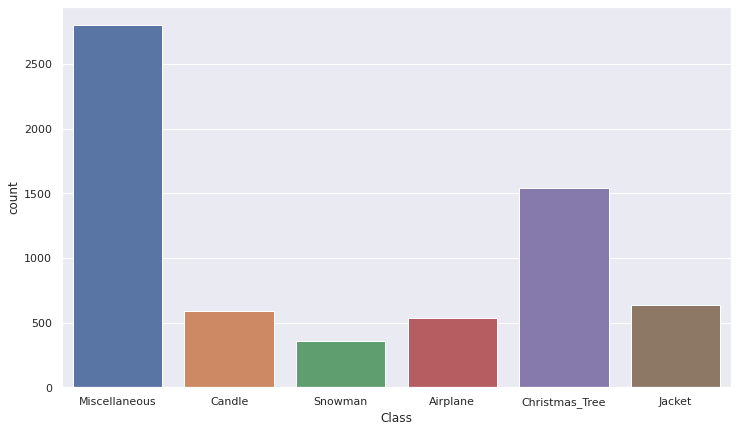

In [6]:
plt.figure(figsize=(12,7))
sns.set(style="darkgrid")
ax = sns.countplot(x="Class", data=train_df)

In [7]:
test_dir = "../input/hackereath-holiday-season-deep-learning-contest/dataset/test"
test_files = []

for file in tqdm(os.listdir(test_dir)):
    test_files.append(file)

test_df = pd.DataFrame(test_files, columns=['Image'])
test_df['Class'] = '0'
test_df.head()

100%|██████████| 3489/3489 [00:00<00:00, 754559.49it/s]


,Image,Class
0,image7761.jpg,0
1,image3202.jpg,0
2,image688.jpg,0
3,image233.jpg,0
4,image4332.jpg,0


## Calculate class-weights

In [8]:
temp_df = train_df.groupby(['Class_enc']).size().reset_index().rename(columns={0:'count'})
total_count = np.sum(temp_df['count'].values)
temp_df['class%'] = (temp_df['count'] / total_count) * 100
lowest_pct = min(temp_df['class%'])
temp_df['class_weight'] = lowest_pct / temp_df['class%']
class_weight = temp_df[['Class_enc', 'class_weight']].to_dict()['class_weight']
class_weight

{0: 0.6747663551401869,
 1: 0.6087689713322091,
 2: 0.23456790123456786,
 3: 0.5640625,
 4: 0.12888254194930382,
 5: 1.0}

## Split training data into train/validation datasets

In [9]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=1)
for train_index, validation_index in sss.split(train_df['Image'], train_df['Class_enc']):
    train_df, validation_df = train_df.iloc[train_index], train_df.iloc[validation_index]

print("train_df shape: {}".format(train_df.shape))
print("validation_df shape: {}".format(validation_df.shape))

train_df shape: (5498, 3)
validation_df shape: (971, 3)


In [10]:
train_df.groupby(['Class','Class_enc']).size().reset_index().rename(columns={0:'Count'})

,Class,Class_enc,Count
0,Airplane,0,455
1,Candle,1,504
2,Christmas_Tree,2,1308
3,Jacket,3,544
4,Miscellaneous,4,2380
5,Snowman,5,307


In [11]:
validation_df.groupby(['Class','Class_enc']).size().reset_index().rename(columns={0:'Count'})

,Class,Class_enc,Count
0,Airplane,0,80
1,Candle,1,89
2,Christmas_Tree,2,231
3,Jacket,3,96
4,Miscellaneous,4,421
5,Snowman,5,54


## Model Hyperparameters

In [12]:
dataset_dir = "../input/hackereath-holiday-season-deep-learning-contest/dataset/"
mini_batch_size = 128
steps_per_epoch = int(np.ceil(train_df.shape[0] / float(mini_batch_size)))
validation_steps = int(np.ceil(validation_df.shape[0] / float(mini_batch_size)))
test_steps = int(np.ceil(test_df.shape[0] / float(mini_batch_size)))
image_dim = (320, 320, 3)

## Configure image generators

In [13]:
train_datagen = ImageDataGenerator(rotation_range = 30,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   height_shift_range = 0.1,
                                   width_shift_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory = os.path.join(dataset_dir,"train"),
                                                    x_col = "Image", 
                                                    y_col = "Class_enc",
                                                    target_size = (image_dim[0], image_dim[1]),
                                                    batch_size = mini_batch_size,
                                                    class_mode = "categorical",
                                                    interpolation="bicubic")

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(validation_df,
                                                              directory = os.path.join(dataset_dir,"train"),
                                                              x_col = "Image",
                                                              y_col = "Class_enc",
                                                              shuffle=False,
                                                              target_size = (image_dim[0], image_dim[1]),
                                                              batch_size = mini_batch_size,
                                                              class_mode = "categorical",
                                                              interpolation="bicubic")

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  directory = os.path.join(dataset_dir,"test"),
                                                  x_col = "Image",
                                                  y_col = "Class",
                                                  shuffle=False,
                                                  target_size = (image_dim[0], image_dim[1]),
                                                  batch_size = mini_batch_size,
                                                  class_mode = "categorical",
                                                  interpolation="bicubic")

Found 5498 validated image filenames belonging to 6 classes.
Found 971 validated image filenames belonging to 6 classes.
Found 3489 validated image filenames belonging to 1 classes.


## Build and validate the model

In [14]:
def head(x_input, input_shape=1792, ratio=8):
    
    #=======================================================
    #                    Channel Attention
    #=======================================================
    gapavg = GlobalAveragePooling2D()(x_input)
    gapavg = Reshape((1, 1, gapavg.shape[1]))(gapavg)
    gapavg = Conv2D(input_shape//ratio, 
                    kernel_size=1, strides=1, use_bias=True, 
                    padding='same', kernel_regularizer=l2(0.001), 
                    kernel_initializer='he_normal')(gapavg)
    gapavg = BatchNormalization()(gapavg)
    gapavg = Activation('relu')(gapavg)
    gapavg_out = Conv2D(input_shape, kernel_size=1, 
                        strides=1, padding='same', use_bias=True, 
                        kernel_regularizer=l2(0.001), 
                        kernel_initializer='he_normal')(gapavg)
    gapavg_out = BatchNormalization()(gapavg_out)
    gapavg_out = Activation('relu')(gapavg_out)


    gmpmax = GlobalMaxPooling2D()(x_input)
    gmpmax = Reshape((1, 1, gmpmax.shape[1]))(gmpmax)
    gmpmax = Conv2D(input_shape//ratio, 
                    kernel_size=1, strides=1, use_bias=True, 
                    padding='same', kernel_regularizer=l2(0.001), 
                    kernel_initializer='he_normal')(gmpmax)
    gmpmax = BatchNormalization()(gmpmax)
    gmpmax = Activation('relu')(gmpmax)
    gmpmax_out = Conv2D(input_shape, kernel_size=1, 
                        strides=1, padding='same', use_bias=True, 
                        kernel_regularizer=l2(0.001), 
                        kernel_initializer='he_normal')(gmpmax)
    gmpmax_out = BatchNormalization()(gmpmax_out)
    gmpmax_out = Activation('relu')(gmpmax_out)
    canx = x_input * tf.math.sigmoid(gapavg_out + gmpmax_out)


    #=======================================================
    #                    Spatial Attention
    #=======================================================
    avg_out = tf.reduce_mean(canx, axis=3)
    max_out = tf.reduce_max(canx,  axis=3)
    x = tf.stack([avg_out, max_out], axis=3)
    
    x = Conv2D(filters=64, kernel_size=3, strides=1, 
               padding='same', use_bias=False, 
               kernel_regularizer=l2(0.001), 
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=32, kernel_size=3, strides=1, 
               padding='same', use_bias=False, 
               kernel_regularizer=l2(0.001), 
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=16, kernel_size=3, strides=1, 
               padding='same', use_bias=False, 
               kernel_regularizer=l2(0.001), 
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=1, kernel_size=3, strides=1, 
               padding='same', use_bias=False, 
               kernel_regularizer=l2(0.001), 
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    spnx1 = canx * x
    spnx2 = x
    
    gapx   = GlobalAveragePooling2D()(spnx1)
    wvgx   = GlobalAveragePooling2D()(spnx2)
    gapavg = Average()([gapx, wvgx])
    x = BatchNormalization()(gapavg)


    #=======================================================
    #                    Tail of the model
    #=======================================================

    x = Dense(units=2048, kernel_regularizer=l2(0.0001), 
              kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(units=1024, kernel_regularizer=l2(0.0001), 
              kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(units=1024, kernel_regularizer=l2(0.0001), 
              kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(units=512, kernel_regularizer=l2(0.0001), 
              kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(units=6, activation='softmax', 
              kernel_initializer='he_uniform')(x)

    return x

In [15]:
# Build the model
base_model = EfficientNetB4(weights='imagenet', 
                            input_tensor=Input(shape=image_dim), 
                            include_top=False)

model = Model(base_model.input, head(base_model.output),
              name='HackerEarth_Holiday_Season_Model')

# Load the pre-trained model
pretrain_model = load_model('../input/holiday-season-enetb4-mav3/hackerearth_holiday_season_model.h5')

# Transfer weights from pre-trained model
model.set_weights(pretrain_model.get_weights())

# Freeze weights for base model
base_model.trainable = False
for layer in base_model.layers[-31:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

# Compile the final model
model.compile(loss='categorical_crossentropy', 
              metrics=[F1Score(num_classes=6, average='weighted'), 
                       'categorical_accuracy'],
              optimizer=Lookahead(AdamW(lr=1e-4, 
                                        weight_decay=1e-5, 
                                        clipvalue=700), 
                                  sync_period=10))

early = EarlyStopping(monitor="val_loss", mode="min", patience=7, 
                      restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, 
                              min_lr=1e-6, patience=5, 
                              verbose=1, mode='min')

chk_point = ModelCheckpoint('hackerearth_holiday_season_model.h5', 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')

71688192/71686520 [==============================] - 1s 0us/step


In [16]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weight, 
    epochs=50, 
    verbose=1, 
    workers=5,
    callbacks=[reduce_lr, early, chk_point], 
    validation_data=validation_generator,
    validation_steps=validation_steps
)

Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 0.0669 - f1_score: 0.9518 - categorical_accuracy: 0.9516
Epoch 00001: val_loss improved from inf to 0.27200, saving model to hackerearth_holiday_season_model.h5
43/43 [==============================] - 173s 4s/step - loss: 0.0669 - f1_score: 0.9518 - categorical_accuracy: 0.9516 - val_loss: 0.2720 - val_f1_score: 0.9251 - val_categorical_accuracy: 0.9248
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.0643 - f1_score: 0.9525 - categorical_accuracy: 0.9523
Epoch 00002: val_loss did not improve from 0.27200
43/43 [==============================] - 143s 3s/step - loss: 0.0643 - f1_score: 0.9525 - categorical_accuracy: 0.9523 - val_loss: 0.2823 - val_f1_score: 0.9249 - val_categorical_accuracy: 0.9248
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 0.0638 - f1_score: 0.9491 - categorical_accuracy: 0.9489
Epoch 00003: val_loss did not improve from 0.27200
43/43 [====================

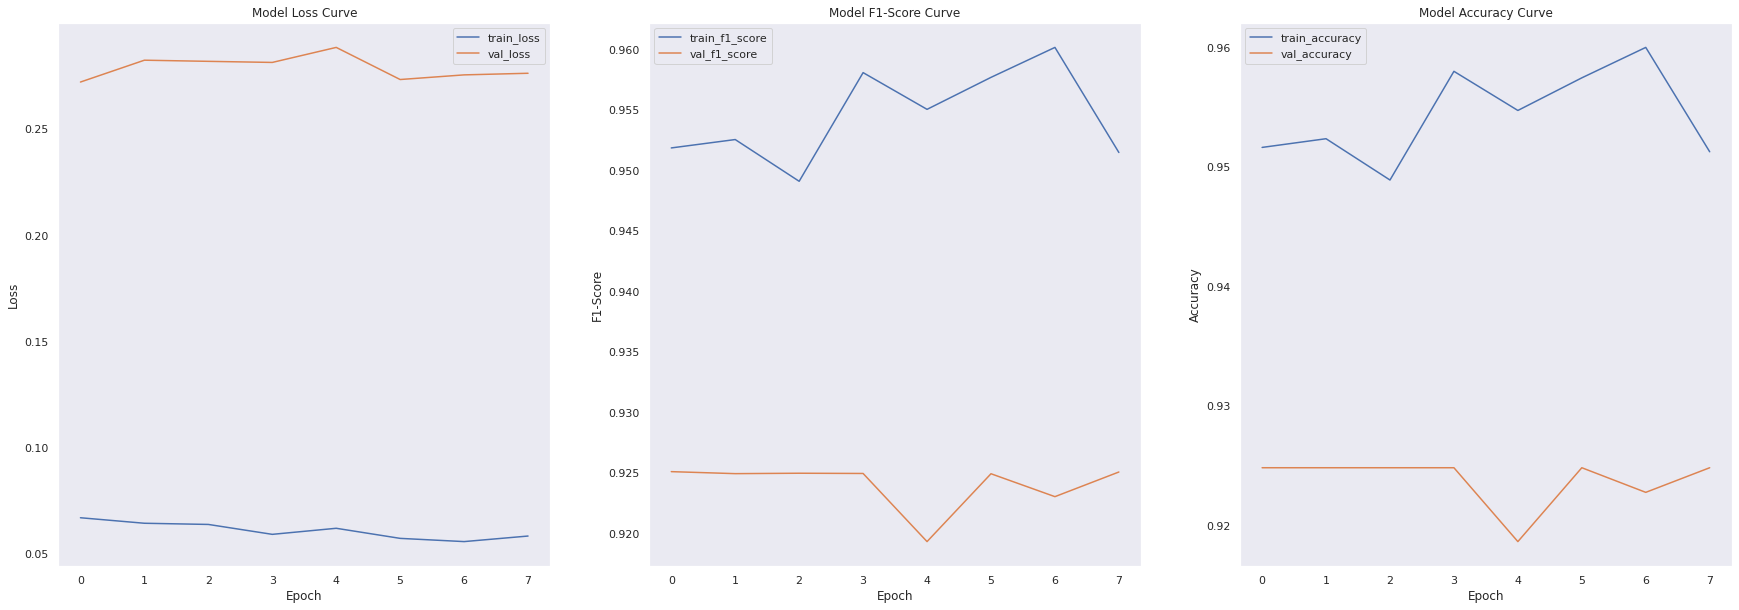

In [17]:
_, ax = plt.subplots(1, 3, figsize=(30, 10))

ax[0].plot(history.history['loss'], label='train_loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title("Model Loss Curve")
ax[0].legend()
ax[0].grid()

ax[1].plot(history.history['f1_score'], label='train_f1_score')
ax[1].plot(history.history['val_f1_score'], label='val_f1_score')
ax[1].set_ylabel('F1-Score')
ax[1].set_xlabel('Epoch')
ax[1].set_title("Model F1-Score Curve")
ax[1].legend()
ax[1].grid()

ax[2].plot(history.history['categorical_accuracy'], label='train_accuracy')
ax[2].plot(history.history['val_categorical_accuracy'], label='val_accuracy')
ax[2].set_ylabel('Accuracy')
ax[2].set_xlabel('Epoch')
ax[2].set_title("Model Accuracy Curve")
ax[2].legend()
ax[2].grid()

## Check classification report

In [18]:
model = load_model('./hackerearth_holiday_season_model.h5')

In [19]:
y_true = np.array([validation_generator.classes]).ravel()
y_pred = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print("\ny_true: {}".format(y_true.shape))
print("y_pred: {}".format(y_pred.shape))

8/8 [==============================] - 6s 751ms/step

y_true: (971,)
y_pred: (971,)


In [20]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92        80
           1       0.92      0.89      0.90        89
           2       0.94      0.92      0.93       231
           3       0.96      0.94      0.95        96
           4       0.93      0.94      0.93       421
           5       0.79      0.91      0.84        54

    accuracy                           0.92       971
   macro avg       0.91      0.91      0.91       971
weighted avg       0.93      0.92      0.93       971



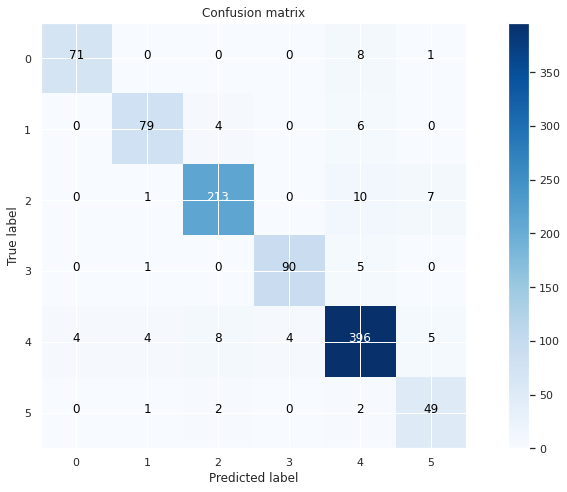

In [21]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5])
np.set_printoptions(precision=2)
plt.figure(figsize=(12,7))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5])

## Create submission file

In [22]:
rev_class_map = {
    0: 'Airplane',
    1: 'Candle',
    2: 'Christmas_Tree',
    3: 'Jacket',
    4: 'Miscellaneous',
    5: 'Snowman'
}

In [23]:
y_pred_final = model.predict(test_generator, verbose=1)
y_pred_final = np.argmax(y_pred_final, axis=1)
print(y_pred_final.shape)

28/28 [==============================] - 35s 1s/step
(3489,)


In [24]:
test_df['Class'] = y_pred_final
test_df['Class'] = test_df['Class'].map(rev_class_map)
test_df.head()

,Image,Class
0,image7761.jpg,Miscellaneous
1,image3202.jpg,Miscellaneous
2,image688.jpg,Snowman
3,image233.jpg,Candle
4,image4332.jpg,Christmas_Tree


In [25]:
test_df.to_csv("/kaggle/working/submission.csv", index=False)